# Ejercicion de programación - Regresión Logistica
https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset
En este ejercicio se implementa regresion logistica y se aplica a dos diferentes datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
import pandas as pd
from sklearn import preprocessing
import csv

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1 Regresion Logistica

En esta parte del ejercicio, creará un modelo de regresión logística para predecir si un estudiante será admitido en una universidad. Suponga que es el administrador de un departamento universitario y desea determinar las posibilidades de admisión de cada solicitante en función de sus resultados en dos exámenes. Tiene datos históricos de solicitantes anteriores que puede usar como un conjunto de capacitación para la regresión logística. Para cada ejemplo de capacitación, se tiene las calificaciones del solicitante en dos exámenes y la decisión de admisión. Su tarea es crear un modelo de clasificación que calcule la probabilidad de admisión de un solicitante en función de los puntajes de esos dos exámenes.

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [ ]:
# Cargar datos
# Las dos primeras columnas contienen la nota de dos examenes y la tercera columna
# contiene la etiqueta que indica si el alumno ingreso o no a la universidad.
#cargado de datos
df = pd.read_csv("/content/drive/MyDrive/IA/datasets/loan_approval_dataset.csv", sep=",")
#elimina la primera columna
df = df.drop('loan_id', axis=1)

df = df.drop(' no_of_dependents', axis=1)
df = df.drop(' education', axis=1)
df = df.drop(' self_employed', axis=1)
df = df.drop(' loan_term', axis=1)

#remplazar valores por los de 1 y 0 a y
diccionarioy = {" Approved": 1, " Rejected": 0}
df[" loan_status"] = df[" loan_status"].replace(diccionarioy)


print(df.head())
print(df.shape)

    income_annum   loan_amount   cibil_score   residential_assets_value  \
0        9600000      29900000           778                    2400000   
1        4100000      12200000           417                    2700000   
2        9100000      29700000           506                    7100000   
3        8200000      30700000           467                   18200000   
4        9800000      24200000           382                   12400000   

    commercial_assets_value   luxury_assets_value   bank_asset_value  \
0                  17600000              22700000            8000000   
1                   2200000               8800000            3300000   
2                   4500000              33300000           12800000   
3                   3300000              23300000            7900000   
4                   8200000              29400000            5000000   

    loan_status  
0             1  
1             0  
2             0  
3             0  
4             0  
(4269, 8

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0    income_annum              4269 non-null   int64
 1    loan_amount               4269 non-null   int64
 2    cibil_score               4269 non-null   int64
 3    residential_assets_value  4269 non-null   int64
 4    commercial_assets_value   4269 non-null   int64
 5    luxury_assets_value       4269 non-null   int64
 6    bank_asset_value          4269 non-null   int64
 7    loan_status               4269 non-null   int64
dtypes: int64(8)
memory usage: 266.9 KB
None


DATOS DE ENTRENAMIENTO 80% ENTRENAMIENTO Y 20% DE TESTEO

In [ ]:
X = df.iloc[:3414, :-1]
X_test = df.iloc[3414:, :-1]
y = df.iloc[:3414, df.columns.get_loc(" loan_status")]
y_test = df.iloc[3414:, df.columns.get_loc(" loan_status")]

Se calcula el valor de la sigmoide aplicando la funcion sigmoid con `z=0`, se debe obtener un resultado de 0.5. RE recomienda experimentar con otros valores de `z`.

<a id="section1"></a>
### 1.2 Implementacion

#### 1.2.1 Fución Sigmoidea

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$.

Los resultados que debe generar la funcion sigmoidea para valores positivos amplios de `x`, deben ser cercanos a 1, mientras que para valores negativos grandes, la sigmoide debe generar valores cercanos 0. La evaluacion de `sigmoid(0)` debe dar un resultado exacto de 0.5. Esta funcion tambien debe poder trabajar con vectores y matrices.

In [ ]:
# Prueba la implementacion de la funcion sigmoid
def sigmoid(z):
    z = np.array(z)
    g = np.zeros(z.shape)
    g = 1 / (1 + np.exp(-z))

    return g

In [ ]:
#peuba de la funcion
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


In [ ]:
def decision(probabilidad):
  punto_corte = 0.5
  return np.where(probabilidad >= punto_corte, 1, 0)

Normalizacion

In [ ]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma


inicializacion de X_norm, mu, sigma

In [ ]:
  X_norm, mu, sigma = featureNormalize(X)

<a id="section2"></a>
#### 1.2.2 Función de Costo y Gradiente

Se implementa la funcion cost y gradient, para la regresión logistica. Antes de continuar es importante agregar el termino de intercepcion a X.

In [ ]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

La funcion de costo en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

In [ ]:
def calcularCosto(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

In [ ]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)

        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

Entrenamiento de los datos

theta calculado por el descenso por el gradiente: [ 1.19179072 -0.23937953  0.41548423  3.09921353 -0.0428984   0.07024086
 -0.09207308 -0.04991097]
Un estudiante con nota del examen 1: 80 y nota del examen 2: 46 (usando el descenso por el gradiente):1


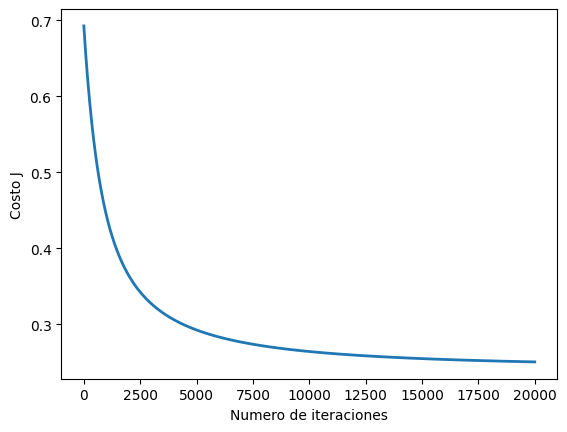

In [ ]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.003
num_iters = 20000

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(8)
theta, J_history = descensoGradiente(theta, X, y, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))

# verificar si ingresa o no a la universidad
X_array = [1,9600000,29900000,778,2400000,17600000,22700000,8000000]
aprueba = sigmoid(np.dot(X_array, theta))   # Se debe cambiar esto

print('el prestamo es: (usando el descenso por el gradiente):{:.0f}'.format(aprueba))

In [ ]:
X_array = [1,9600000,29900000,778,2400000,17600000,22700000,8000000]
y_predicted = sigmoid(np.dot(X_array, theta))
print('el prestamo fue 1=aprobado, 0=desaprobado -> :{:.0f}'.format(y_predicted))

Un estudiante con nota examen 1: 20 y nota examen 2: 80 -> :1


# Se aplica en X_tes la facturalizacion y se agregan las columna de unos

In [ ]:
X_test, mu, sigma = featureNormalize(X_test)
m, n = X_test.shape
X_test = np.concatenate([np.ones((m, 1)), X_test], axis=1)
aprueba = sigmoid(np.dot(X_test, theta))

# Test con el 20% de datos

In [ ]:
probabilidad = sigmoid(np.dot(X_test, theta))
resultado = decision(probabilidad)
print(resultado)

[0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1
 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1
 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0
 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0
 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1
 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0
 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1
 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0
 0 1 1 1 1 0 0 1 1 0 1 0 

In [ ]:
def costFunction(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    grad = (1 / m) * (h - y).dot(X)

    return J, grad

Se prueba la funcion `costFunction` utilizando dos casos de prueba para $\theta$.

In [ ]:
# Inicializacion de parametros de ajuste
initial_theta = np.zeros(n+1)
print(initial_theta)
cost, grad = costFunction(initial_theta, X, y)

print('Costo en theta inicial (zeros): {:.3f}'.format(cost))
print('Costo esperado (aproximado): 0.693\n')
print(grad)
print('Gradiente en theta inicial (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Gradiente esperado (aproximado):\n\t[-0.1000, -12.0092, -11.2628]\n')



[0. 0. 0. 0. 0. 0. 0. 0.]
Costo en theta inicial (zeros): 0.693
Costo esperado (aproximado): 0.693

[-0.11540715  0.00424959 -0.01418381 -0.3763322   0.00939064 -0.00825008
  0.00434544  0.00171736]
Gradiente en theta inicial (zeros):
	[-0.1154, 0.0042, -0.0142]
Gradiente esperado (aproximado):
	[-0.1000, -12.0092, -11.2628]



In [ ]:
# Calcula y muestra el costo y el gradiente con valores de theta diferentes a cero
test_theta = np.array(X[1])
#test_theta = np.array([-24, 0.2, 0.2])
#test_theta = np.array([-11.74749157, 0.09927308, 0.09316497])
print(test_theta)
cost, grad = costFunction(test_theta, X, y)

print('Costo en theta prueba: {:.3f}'.format(cost))
print('Costo esperado (aproximado): 0.218\n')

print('Gradiente en theta prueba:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Gradiente esperado (aproximado):\n\t[0.043, 2.566, 2.647]')

[ 1.         -0.33214962 -0.31586072 -1.04980407 -0.72514017 -0.62642596
 -0.69117356 -0.50796994]
Costo en theta prueba: 1.721
Costo esperado (aproximado): 0.218

Gradiente en theta prueba:
	[0.003, -0.308, -0.311]
Gradiente esperado (aproximado):
	[0.043, 2.566, 2.647]


#### 1.2.3 Parámetros de aprendizaje usando `scipy.optimize`

En el codigo anterior se encontró los parámetros óptimos de un modelo de regresión lineal al implementar el descenso de gradiente. Se implemento una función de costo y se calculó su gradiente, utilizando el algoritmo del descenso por el gradiente.

En lugar de realizar los pasos del descenso por el gradiente, se utilizará el [módulo `scipy.optimize`] (https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy es una biblioteca de computación numérica para `python`. Proporciona un módulo de optimización para la búsqueda y minimización de raíces. A partir de `scipy 1.0`, la función` scipy.optimize.minimize` es el método a utilizar para problemas de optimización (tanto restringidos como no restringidos).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:

Para la regresión logística, se desea optimizar la función de costo $J(\theta)$ con los parámetros $\theta$.
Concretamente, se va a utilizar `optimize.minimize` para encontrar los mejores parámetros $\theta$ para la función de costo de regresión logística, dado un dataset fijo (de valores X e y). Se pasara a `optimize.minimize` las siguientes entradas:

- `costFunction`: Una función de costo que, cuando se le da el dataset de entrenamiento y un $\theta$ particular, calcula el costo de regresión logística y el gradiente con respecto a $\theta$ para el dataset(X, y). Es importante tener en cuenta que solo se pasa el nombre de la función sin el paréntesis. Esto indica que solo proporcionamos una referencia a esta función y no evaluamos el resultado de esta función.
- `initial_theta`: Los valores iniciales de los parametros que se tratan de optimizar.
- `(X, y)`: Estos son argumentos adicionales a la funcion de costo.
- `jac`: Indicación si la función de costo devuelve el jacobiano (gradiente) junto con el valor de costo. (True)
- `method`: Método / algoritmo de optimización a utilizar
- `options`: Opciones adicionales que pueden ser específicas del método de optimización específico. Solo se indica al algoritmo el número máximo de iteraciones antes de que termine.

Si se ha completado la `costFunction` correctamente,`optimize.minimize` convergerá en los parámetros de optimización correctos y devolverá los valores finales del costo y $\theta$ en un objeto de clase.

Al usar `optimize.minimize`, no se tuvo que escribir ningún bucle ni establecer una tasa de aprendizaje como se hizo para el descenso de gradientes. Todo esto se hace mediante `optimize.minimize`: solo se necesita proporcionar una función que calcule el costo y el gradiente.

A continuación, se tiene el código para llamar a `optimize.minimize` con los argumentos correctos.

In [ ]:
# Establecer las opciones para optimize.minimize
options= {'maxiter': 1000}

# revisar la documentacion de scipy's optimize.minimize para mayor descripcion de los parametros
# La funcion devuekve un objeto `OptimizeResult`
# Se utiliza el algoritmo de Newton truncado para la optimización.
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# la propiedad fun del objeto devuelto por `OptimizeResult`
# contiene el valor del costFunction de un theta optimizado
cost = res.fun

# Theta optimizada esta en la propiedad x
theta = res.x

# Imprimir theta en la pantalla
print('Costo con un valor de theta encontrado por optimize.minimize: {:.3f}'.format(cost))
print('Costo esperado (aproximado): 0.203\n');

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))
print('Theta esperado (aproximado):\n\t[-25.161, 0.206, 0.201]')

Costo con un valor de theta encontrado por optimize.minimize: 0.242
Costo esperado (aproximado): 0.203

theta:
	[1.550, -1.516, 1.278]
Theta esperado (aproximado):
	[-25.161, 0.206, 0.201]


<ipython-input-54-0dfcfa2e2ef1>:7: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunction,


Una vez que se completa `optimize.minimize`, se usa el valor final de $\theta$ para visualizar el límite de decisión en los datos de entrenamiento.

Para hacerlo, se implementa la función `plotDecisionBoundary` para trazar el límite de decisión sobre los datos de entrenamiento.

<a id="section4"></a>
#### 1.2.4 Evaluación de la regresión logistica

Después de aprender los parámetros, se puede usar el modelo para predecir si un estudiante en particular será admitido. Para un estudiante con una puntuación en el Examen 1 de 45 y una puntuación en el Examen 2 de 85, debe esperar ver una probabilidad de admisión de 0,776. Otra forma de evaluar la calidad de los parámetros que hemos encontrado es ver qué tan bien predice el modelo aprendido en nuestro conjunto de entrenamiento.

In [ ]:
def predict(theta, X):
    """
    Predecir si la etiqueta es 0 o 1 mediante regresión logística aprendida.
    Calcula las predicciones para X usando un umbral en 0.5 (es decir, si sigmoide (theta.T * x)> = 0.5, predice 1)

    Parametros
    ----------
    theta : array_like
        Parametros para regresion logistica. Un vecto de la forma (n+1, ).

    X : array_like
        Datos utilizados para el calculo de las predicciones.
        La fila es el numero de los puntos para calcular las predicciones,
        y las columnas con el numero de caracteristicas.

    Devuelve
    -------
    p : array_like
        Predicciones y 0 o 1 para cada fila en X.
    """
    m = X.shape[0] # Numero de ejemplo de entrenamiento

    p = np.zeros(m)

    p = np.round(sigmoid(X.dot(theta.T)))
    return p

Una vez entrenado el modelo se procede a realizar la prediccion y evaluación de los resultados de predecir cual es el valor que vota el modelo para todos los datos utilizados en el entrenamiento.

In [ ]:
#  Predice la probabilidad de ingreso para un estudiante con nota de 45 en el examen 1 y nota de 85 en el examen 2
prob = sigmoid(np.dot([1,9600000,29900000,778,2400000,17600000,22700000,8000000], theta))
print('Para un estudiante con notas de 45 y 85, se predice una probabilidad de admisión de: {:.3f}%'.format(prob))
print('Valor esperado: 0.775 +/- 0.002\n')

# Compute accuracy on our training set
p = predict(theta, X)
print('Precisión de entrenamiento: {:.2f} %'.format(np.mean(p == y) * 100))
print('Precisión esperada (aproximadamente): 89.00 %')

Para un estudiante con notas de 45 y 85, se predice una probabilidad de admisión de: 1.000%
Valor esperado: 0.775 +/- 0.002

Precisión de entrenamiento: 92.53 %
Precisión esperada (aproximadamente): 89.00 %
